# Курсовой проект для курса "Python для Data Science"
#### Материалы к проекту (файлы):
train.csv
test.csv
#### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.
#### Целевая переменная:
Price
#### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size' : 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, 
                   test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, 
                                        train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, 
                                       test_pred_values), 3)))
    
    plt.figure(figsize=(18, 10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True sample prediction')
    
    plt.show()

### Путь к файлу 

In [4]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Загрузка данных

#### Описания полей датасета по недвижимости

Id - идентификационный номер квартиры,

DistrictId - идентификационный номер района,

Rooms - количество комнат,

Square - площадь,

LifeSquare - жилая площадь,

KitchenSquare - площадь кухни,

Floor - этаж,

HouseFloor - количество этажей в доме,

HouseYear - год постройки дома,

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,

Social_1, Social_2, Social_3 - социальные показатели местности,

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,

Price - цена квартиры.

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Обзор данных

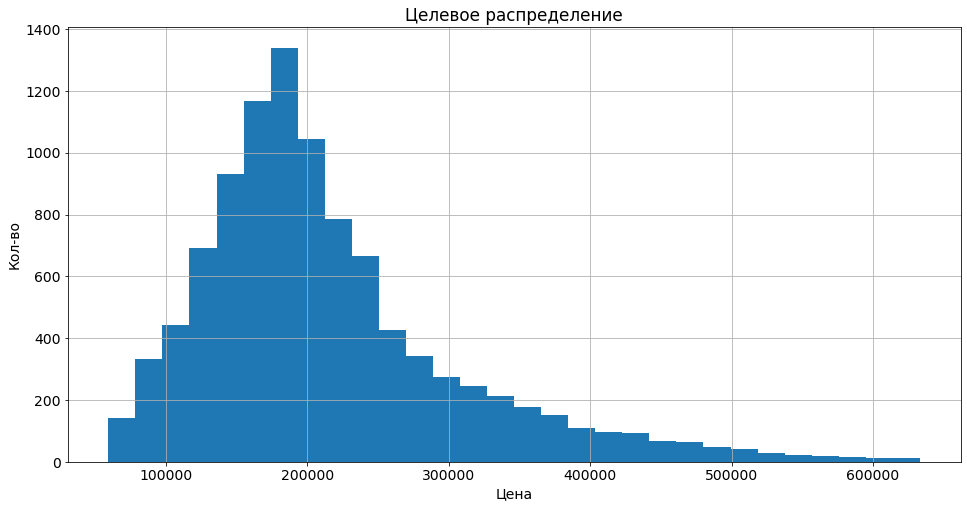

In [9]:
plt.figure(figsize= (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Кол-во')
plt.xlabel('Цена')
plt.title('Целевое распределение')
plt.show()

### Приведение типов

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df['Id'] = train_df['Id'].astype('str')
train_df['DistrictId'] = train_df['DistrictId'].astype('str')
train_df['Rooms'] = train_df['Rooms'].astype('int64')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int64')

### Проверка данных

In [12]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


### 1. Обработка аномалий, выбросов и пропусков

#### 1.1. Rooms

In [13]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [14]:
train_df.loc[train_df['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056975,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19,42.006046,21.779288,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6,59.414334,38.702244,6.0,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10,60.871266,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [15]:
train_df.loc[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [16]:
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'
            ] = train_df['Rooms'].median()

#### 1.2. Square, LifeSquare, KitchenSquare

In [17]:
train_df = train_df[train_df['Square'].isnull() | 
                    (train_df['Square'] < train_df['Square'].quantile(.975)) | 
                    (train_df['Square'] > train_df['Square'].quantile(.025))]

train_df = train_df[train_df['LifeSquare'].isnull() | 
                   (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) |
                   (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]

train_df = train_df[train_df['KitchenSquare'].isnull() | 
                   (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [18]:
train_df.shape

(9744, 20)

#### 1.3. HouseFloor, Floor

In [19]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  32,  37,  38,  39,  40,  44,  45,  48,
        99, 117], dtype=int64)

In [20]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [21]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [22]:
floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_out, 'Floor'] = train_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### 1.4. HouseYear

In [23]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
7076        2020
2493        2020
4053        2020
          ...   
8505        1918
8144        1917
1380        1917
5053        1917
910         1914
Name: HouseYear, Length: 9744, dtype: int64

In [24]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = random.randint(2005, 2011)

#### 1.5. Обработка пропусков 

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9744 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9744 non-null   object 
 1   DistrictId     9744 non-null   object 
 2   Rooms          9744 non-null   int64  
 3   Square         9744 non-null   float64
 4   LifeSquare     7642 non-null   float64
 5   KitchenSquare  9744 non-null   float64
 6   Floor          9744 non-null   int64  
 7   HouseFloor     9744 non-null   int64  
 8   HouseYear      9744 non-null   int64  
 9   Ecology_1      9744 non-null   float64
 10  Ecology_2      9744 non-null   object 
 11  Ecology_3      9744 non-null   object 
 12  Social_1       9744 non-null   int64  
 13  Social_2       9744 non-null   int64  
 14  Social_3       9744 non-null   int64  
 15  Healthcare_1   5071 non-null   float64
 16  Helthcare_2    9744 non-null   int64  
 17  Shops_1        9744 non-null   int64  
 18  Shops_2 

In [26]:
#Пропуски в LifeSquare и Healthcare_1

#### LifeSquare

In [27]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

#### Healthcare_1 

In [28]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9744 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9744 non-null   object 
 1   DistrictId     9744 non-null   object 
 2   Rooms          9744 non-null   int64  
 3   Square         9744 non-null   float64
 4   LifeSquare     9744 non-null   float64
 5   KitchenSquare  9744 non-null   float64
 6   Floor          9744 non-null   int64  
 7   HouseFloor     9744 non-null   int64  
 8   HouseYear      9744 non-null   int64  
 9   Ecology_1      9744 non-null   float64
 10  Ecology_2      9744 non-null   object 
 11  Ecology_3      9744 non-null   object 
 12  Social_1       9744 non-null   int64  
 13  Social_2       9744 non-null   int64  
 14  Social_3       9744 non-null   int64  
 15  Healthcare_1   9744 non-null   float64
 16  Helthcare_2    9744 non-null   int64  
 17  Shops_1        9744 non-null   int64  
 18  Shops_2 

### Построение признаков

#### Dummies

In [30]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A' : 0, 'B' : 1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A' : 0, 'B' : 1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A' : 0, 'B' : 1})

####  District (Size, Large)

In [31]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index' : 'DistrictId', 'DistrictId' : 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,810
1,1,646
2,23,546
3,6,503
4,9,292


In [32]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,22
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,170
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,174
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,97


In [33]:
(train_df['DistrictSize'] > 100).value_counts()

True     4943
False    4801
Name: DistrictSize, dtype: int64

In [34]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### PriceByDistrictMedian

In [35]:
med_price_dist = train_df.groupby(['DistrictId', 'Rooms'], as_index=False)\
                        .agg({'Price' : 'median'}).rename(columns={'Price' : 'MedPriceDist'})
med_price_dist.head()

,DistrictId,Rooms,MedPriceDist
0,0,1,142486.170594
1,0,2,176210.812334
2,0,3,308098.189977
3,1,1,147110.201250
4,1,2,202626.530012


In [36]:
train_df = train_df.merge(med_price_dist, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceDist
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,297041.145784
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,1,3,B,220925.908524,1,1,1,170,1,261705.465881
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,0,5,B,175616.227217,1,1,1,174,1,166809.665642
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,2,4,B,150226.531644,1,1,1,97,0,158539.052715


### Отбор признаков

In [37]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceDist']

In [38]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                  'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge']#, 'MedPriceDist']
target_name = 'Price'

### Разбиение на train и test

In [39]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

### Построение модели

In [41]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.963
Test R2:	0.701


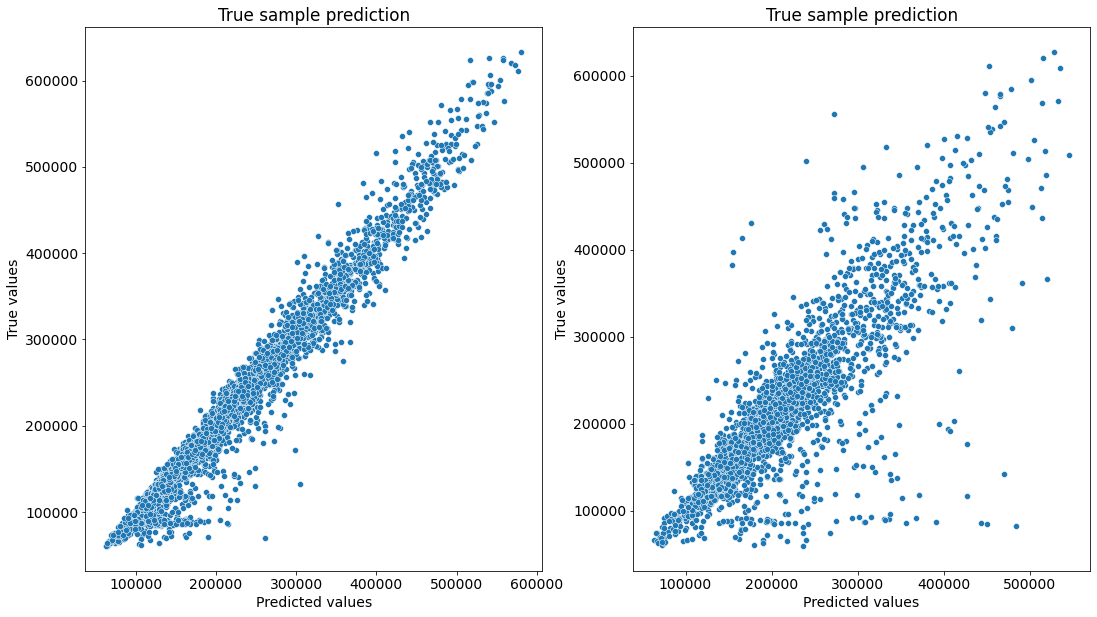

In [42]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Перекрёстная проверка

In [43]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.7020398 , 0.73330825, 0.73819663])

In [44]:
cv_score.mean()

0.724514893678125

## Прогнозирование на тестовом датасете

In [45]:
#test_df

In [46]:
test_df['Id'] = test_df['Id'].astype('str')
test_df['DistrictId'] = test_df['DistrictId'].astype('str')
test_df['Rooms'] = test_df['Rooms'].astype('int64')
test_df['HouseFloor'] = test_df['HouseFloor'].astype('int64')

In [47]:
test_df.loc[test_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'
            ] = test_df['Rooms'].median()

In [48]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [49]:
floor_out = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[floor_out, 'Floor'] = test_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [50]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

In [51]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [52]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [53]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A' : 0, 'B' : 1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A' : 0, 'B' : 1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A' : 0, 'B' : 1})

In [54]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index' : 'DistrictId', 'DistrictId' : 'DistrictSize'})

In [55]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')

In [56]:
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [57]:
#######################

In [58]:
X2 = test_df[feature_names + new_feature_names]

In [59]:
test_features = list(X_train.columns)

In [60]:
test_df[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rooms            5000 non-null   int64  
 1   Square           5000 non-null   float64
 2   LifeSquare       5000 non-null   float64
 3   KitchenSquare    5000 non-null   float64
 4   Floor            5000 non-null   int64  
 5   HouseFloor       5000 non-null   int64  
 6   HouseYear        5000 non-null   int64  
 7   Ecology_1        5000 non-null   float64
 8   Social_1         5000 non-null   int64  
 9   Social_2         5000 non-null   int64  
 10  Social_3         5000 non-null   int64  
 11  Healthcare_1     5000 non-null   float64
 12  Helthcare_2      5000 non-null   int64  
 13  Shops_1          5000 non-null   int64  
 14  Ecology_2_bin    5000 non-null   int64  
 15  Ecology_3_bin    5000 non-null   int64  
 16  Shops_2_bin      5000 non-null   int64  
 17  IsDistrictLarg

In [61]:
test_df['Price'] = rf_model.predict(test_df[test_features])

In [63]:
from scipy.stats import norm
from scipy import stats

mu = 215725.33 and sigma = 79903.55


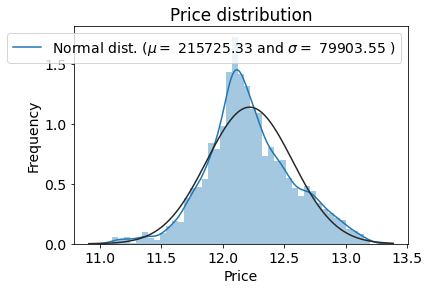

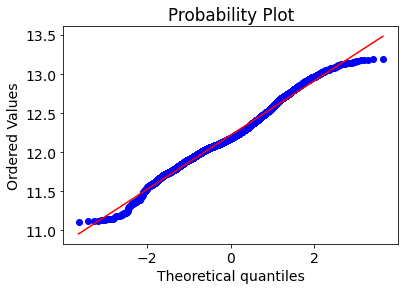

In [64]:
price_log = np.log1p(test_df['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(test_df['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [67]:
test_df[['Id', 'Price']].to_csv('MKalaev_predictions.csv', index=None, )